In [1]:
import numpy as np, pandas as pd, os, re, datetime as dt, scipy
from pathlib import Path
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
from utils import *

# For testing purposes
CHECKUP_FOLDER = Path('./Results/Checkup')
Path.mkdir(CHECKUP_FOLDER, exist_ok=True, parents=True)

vaccine_shorts

{'Вакцина для профілактики поліомієліту (оральна)': 'ОПВ',
 'Вакцина для профілактики поліомієліту (інактивована)': 'ІПВ',
 'Вакцина для профілактики туберкульозу': 'БЦЖ',
 'Вакцина для профілактики кашлюку, дифтерії та правця з цільноклітинним кашлюковим компонентом': 'АКДП',
 'Вакцина для профілактики кору, паротиту та краснухи': 'КПК',
 'Вакцина для профілактики гепатиту В для дітей': 'ГепВ-Дит',
 'Вакцина для профілактики гепатиту В для дорослих': 'ГепВ-Дор',
 'Вакцина для профілактики правця': 'Правець',
 'Анатоксин для профілактики дифтерії та правця (АДП)': 'АДП',
 'Анатоксин для профілактики дифтерії та правцю з зменшеним вмістом антигену (АДП-М)': 'АДП-М',
 'Вакцина для профілактики гемофільної інфекції типу b': 'ХІБ',
 'Комбінована вакцина для профілактики кашлюка з цільноклітинним кашлюковим компонентом, дифтерії, правця, гепатиту В та гемофільної інфекції типу b': 'Пента',
 'Комбінована вакцина для профілактики дифтерії, правця, коклюшу, гемофільної інфекції та поліомієліту

In [2]:
import utils, importlib
importlib.reload(utils)
ukraine_map_json = utils.ukraine_map_json

In [3]:
LATEST_FILE = sorted([filename for filename in DATA_FOLDER.iterdir() if filename.stem not in ['.DS_Store', 'Auxillary']], key=lambda fn: dt.date.fromisoformat(fn.name[-5 - 10:-5]))[-1]
LATEST_FILE.name

'ВСЬОГО – 2024-01-02.xlsx'

In [4]:
# sheet_id = "1koUddJooo_5mQAssJKISCSXJGEIhIxfrWGRpzwYIZ1o"
# sheet_name = "Всього"
# url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={1245452}"
# dfs = []

sorted_files = sorted([filename for filename in DATA_FOLDER.iterdir() if filename.stem not in ['.DS_Store', 'Auxillary']], key=lambda fn: dt.date.fromisoformat(fn.name[-5 - 10:-5]))

LATEST_FILE = sorted_files[-1]


for filepath in sorted_files:
    if filepath.name.startswith('~') or '.DS_Store' in filepath.name:
        continue

    if filepath == LATEST_FILE:
        pattern = r'(\d{4})-(\d{2})-(\d{2})'
        date_match = re.search(pattern, filepath.name)

        if date_match:
            year = date_match.group(1)
            month = date_match.group(2)
            day = date_match.group(3)

        df = pd.read_excel(filepath, sheet_name='Залишки поточні', dtype={' код ЄДРПОУ': str}, engine='openpyxl')
        df.columns = df.columns.str.strip()
        df.rename(columns={'Серія препарту': 'Серія препарату'}, inplace=True)

        # df['код ЄДРПОУ'] = df['код ЄДРПОУ'].astype(int, errors='ignore')
        df['Заклад'] = df['Заклад'].str.strip()
        df['Кількість доз'] = df['Кількість доз'].astype(int)
        df['Регіон'] = df['Регіон'].str.replace(' область', '')
        

# ———————————————————————————— Визначити назву вакцини за серією препарату і переписати назви у вхідних даних ————————————————————————————
series_df = df.groupby(['Серія препарату'])['Міжнародна непатентована назва'].apply(lambda vaccines: [[vaccine, len(vaccines[vaccines==vaccine])] for vaccine in vaccines.unique() if not pd.isna(vaccine)]).reset_index()

# Серії без жодної назви препарату
series_df[series_df['Міжнародна непатентована назва'].apply(lambda vaccines: len(vaccines))==0].to_excel(RESULTS_FOLDER / 'Серії без назв препаратів.xlsx', index=None)
# Серії з багатьма варіантами назв препаратів
series_df[series_df['Міжнародна непатентована назва'].apply(lambda vaccines: len(vaccines))>1].to_excel(RESULTS_FOLDER / 'Серії з багатьма варіантами назв препаратів.xlsx', index=None)

# Залишити тільки серії, де є хоча б одна назва препарату
series_df = series_df[~(series_df['Міжнародна непатентована назва'].apply(lambda vaccines: len(vaccines))==0)]

# Обрати назву препарату, яка найчастіше зустрічається в серії
overwritings = series_df.apply(lambda row: max(row['Міжнародна непатентована назва'], key=lambda pair: pair[1])[0], axis=1)
series_df['Назва препарату'] = overwritings

series_df = series_df[['Серія препарату', 'Назва препарату']].set_index('Серія препарату')

df['Міжнародна непатентована назва'] = df[['Серія препарату', 'Міжнародна непатентована назва']].apply(lambda row: series_df.to_dict()['Назва препарату'].get(row['Серія препарату'], row['Міжнародна непатентована назва']), axis=1)
# ————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————

# ————————————————————————————————————————————————————— Temporary Middleware Section —————————————————————————————————————————————————————
# df['дата оновлення'].replace(dt.datetime(203, 12, 7, 0, 0), dt.datetime(2023, 12, 7, 0, 0), inplace=True)
df = df[df["Міжнародна непатентована назва"].notna()]
df['Регіон'] = df['Регіон'].replace('чЕРНІГІВСЬКА ОБЛАСТЬ', 'Чернігівська область')
# ————————————————————————————————————————————————————— Temporary Middleware Section —————————————————————————————————————————————————————

vaccines = sorted(df['Міжнародна непатентована назва'].dropna().unique())

df['Міжнародна непатентована назва'] = df['Міжнародна непатентована назва'].replace(vaccine_shorts)

df['Термін придатності'] = pd.to_datetime(df['Термін придатності']).dt.date
df['дата оновлення'] = pd.to_datetime(df['дата оновлення']).dt.date

df = df[df['Термін придатності'] >= df['дата оновлення']]

df = df[~df['Міжнародна непатентована назва'].isin(['Правець', 'ДПКГП'])]

REPORT_DATE = df['дата оновлення'].max()

# Add national leftovers data
national_leftovers_df = pd.read_excel(DATA_FOLDER/'Auxillary'/'Залишки нацрівня.xlsx')
national_leftovers_df.rename(columns={'Вакцина': 'Міжнародна непатентована назва', 'Залишок': 'Кількість доз'}, inplace=True)
national_leftovers_df['Регіон'] = 'Україна'
national_leftovers_df['Термін придатності'] = national_leftovers_df['Термін придатності'].dt.date 
df = pd.concat([df, national_leftovers_df], ignore_index=True)

# Create a set of different diseases we have vaccines for
# diseases_set = set(disease_vaccine_dict.keys())

df

,код ЄДРПОУ,Заклад,Серія препарату,Міжнародна непатентована назва,Торгівельна назва,Виробник,Термін придатності,Джерело фінансування,Кількість доз,дата оновлення,Регіон
0,35527334,"КНП ""ЦПМСД №1"" м. Вінниця",1141M019A,ХІБ,ВАКЦИНА КОН`ЮГОВАНА ДЛЯ ПРОФІЛАКТИКИ ЗАХВОРЮВА...,"СЕРУМ ІНСТИТУТ ІНДІЇ ПВТ. ЛТД., Індія",2024-05-21,Державний бюджет 2021,94,2023-12-29,Вінницька
1,35527334,"КНП ""ЦПМСД №1"" м. Вінниця",0401622,АДП,"АДСОРБОВАНА ВАКЦИНА ДТ / ADSORBED DT VACCINE, ...","ПТ БІО ФАРМА (Персеро), Індонезія",2025-12-21,Державний бюджет 2021,38,2023-12-29,Вінницька
2,35527334,"КНП ""ЦПМСД №1"" м. Вінниця",X007788,КПК,"MMRVAXPRO II 0,5ML 10X1DOSE VIAL L25","Merck & Co., Inc.",2024-07-20,Гуманітарна допомога,35,2023-12-29,Вінницька
3,35527334,"КНП ""ЦПМСД №1"" м. Вінниця",D2708,АДП-М,"ТЕТАДІФ суспензія для ін'єкцій 0,5 мл (1 доза)...",ББ-НЦІПХЛтд. Болгарія,2025-11-30,Державний бюджет 2021,140,2023-12-29,Вінницька
4,35527334,"КНП ""ЦПМСД №1"" м. Вінниця",2249001B,ІПВ,Inactivated Poliomyelitis Vaccine,Bilthoven Biologicals B.V.,2025-12-08,Гуманітарна допомога,67,2023-12-29,Вінницька
...,...,...,...,...,...,...,...,...,...,...,...
15673,2006722,"КНП ""Клініка""Сімейний лікар"" Широківської с/р",62С23012А,Сказ,"ІНДІРАБ ВАКЦИНА АНТИРАБІЧНА ОЧИЩЕНА, ІНАКТИВОВ...","ТОВ ""Фарма Лайф"", Україна",2026-02-28,Державний бюджет 2021,10,2023-12-29,Запорізька
15674,NaN,NaN,NaN,КПК,NaN,NaN,2025-03-09,NaN,12000,NaN,Україна
15675,NaN,NaN,NaN,КПК,NaN,NaN,2025-03-09,NaN,94770,NaN,Україна
15676,NaN,NaN,NaN,КПК,NaN,NaN,2025-03-14,NaN,70980,NaN,Україна


#### Клітинки для тестів

In [5]:
# df[ (df['Заклад'].isna()) | (df['Заклад'].str.strip() == '') ]
# df[ (df['Регіон'] == 'Закарпатська область') & (df['Міжнародна непатентована назва'] == 'Комбінована вакцина для профілактики дифтерії, правця, коклюшу, гемофільної інфекції та поліомієліту') ]
# df[df['Термін придатності'] < df['дата оновлення']]
REPORT_DATE

datetime.date(2024, 1, 4)

## Create an HTML report with all Leftovers included

### Regional Part

In [6]:
region_df = df.groupby(["Регіон", "Міжнародна непатентована назва"])[['Кількість доз']].sum().reset_index()

region_df = region_df.pivot_table(values='Кількість доз', columns='Регіон', index='Міжнародна непатентована назва').fillna(0).astype(int).T

region_df.sort_index(key=lambda index: pd.Index(region_positions[x] for x in index), inplace=True)
region_df

Міжнародна непатентована назва,ІПВ,АДП,АДП-М,АКДП,БЦЖ,ГепВ-Дит,ГепВ-Дор,КПК,ОПВ,Пента,Сказ,ХІБ
Регіон,,,,,,,,,,,,
Вінницька,8591,7465,23049,14195,14490,1835,1155,14077,4129,5654,6848,3639
Волинська,4109,3876,11194,9527,10550,3163,1158,7118,4572,4995,1432,191
Дніпропетровська,16739,13769,20738,22998,13730,4683,3685,11703,11586,11121,3608,1278
Донецька,581,988,1434,1883,4290,2536,2613,1059,46,1893,2410,591
Житомирська,4856,5662,8824,7402,10730,1060,0,9224,3190,5630,3550,531
Закарпатська,11219,7223,16018,7966,9831,2291,0,8171,5841,4995,1313,5303
Запорізька,3527,3262,8031,3027,3280,4958,3340,1830,4058,2919,1575,2257
Івано-Франківська,14519,4937,22955,14317,13330,1232,0,14756,19566,4437,1920,740
Київська,14947,8321,13541,18289,18830,3980,1257,17670,2765,4990,3006,1911


In [7]:
region_df.to_excel(CHECKUP_FOLDER / f'Залишки по регіонах на {REPORT_DATE}.xlsx')

In [8]:
vaccines_left_sorted = region_df.sum(axis=0).sort_values(ascending=False).to_frame()
vaccines_left_sorted

,0
Міжнародна непатентована назва,
АДП-М,389033
КПК,368807
БЦЖ,300617
АКДП,296002
Пента,189261
ІПВ,171423
АДП,124527
ОПВ,108400
Сказ,60263


#### Протерміновані звіти про вакцини

In [9]:
timed_out_reports = df[(REPORT_DATE - df['дата оновлення']) > dt.timedelta(days=7)]
timed_out_reports = timed_out_reports.groupby('Регіон')[['Кількість доз', 'Заклад']].apply(lambda group: [group['Кількість доз'].sum(), len(group['Заклад'].unique())]).sort_values(ascending=False)

unknown_vaccine_leftovers_html = f"""
<div class="level-item has-text-centered">
    <div>
        <p class="heading mb-3">Залишки, прозвітовані більше, ніж 7 днів тому</p>
        <p class="title has-text-light">{int(df[(REPORT_DATE - df['дата оновлення']) > dt.timedelta(days=7)]['Кількість доз'].sum()):,}</p>
    </div>
</div>
"""

timed_out_reports
timed_out_reports.to_json(orient='split', force_ascii=False),

('{"name":null,"index":["м. Київ","Львівська","Житомирська"],"data":[[145607,65],[130548,138],[60659,80]]}',)

#### Дефіцитні вакцини

In [10]:
regions_to_watch_html = """
<div class="level-item full-width">
    <div class="columns is-multiline is-centered">
        <div class="column is-full has-text-centered">
            <p class="title is-4 has-text-light">
                Дефіцитні вакцини:
            </p>
        </div>
"""
temp_region_df = region_df

region_df = region_df.loc[region_df.index!="Україна"].copy()

regions_and_vaccine_to_watch = []
for column in region_df.columns:
    if column == 'Україна':
        continue
    vaccine_threshold = region_df.sum(axis=0)/len(region_df.columns)/5
    presence_count = (region_df[column] > vaccine_threshold[column]).sum()
    absence_count = (region_df[column] <= vaccine_threshold[column]).sum()

    if presence_count > 18 and absence_count > 0:
        regions_without_vaccine = region_df[
            region_df[column] <= vaccine_threshold[column]
        ].index.tolist()
            
        regions_to_watch_html += f"""
        <div class="column is-4 has-text-centered">
            <div>
                <p class="title is-5 has-text-light mb-5">{column}</p>
                <p class="heading is-5 has-text-light">{', '.join(regions_without_vaccine)}</p>
            </div>
        </div>
        """

regions_to_watch_html+="""</div>
</div>"""

region_df = temp_region_df

#### Знайти регіони, де немає вакцин проти всіх хвороб, а також хвороби, проти яких немає вакцин

In [11]:
# Step 1: Group the dataframe by regions and for each group, get the set of diseases that can be prevented by the vaccines available in the region
region_diseases = df[df['Кількість доз']>0].groupby('Регіон')['Міжнародна непатентована назва'].apply(
    lambda vaccines: set(disease for vaccine in set(vaccines) for disease, vaccine_list in disease_vaccine_dict.items() if vaccine in vaccine_list)
)
# Step 2: Compare the set of diseases for each region with the set of diseases from the dictionary
regions_without_all_diseases = region_diseases[region_diseases.apply(lambda x: not diseases_set.issubset(x))]

# Step 3: For each such region, find the diseases for which vaccines are missing
missing_diseases = regions_without_all_diseases.apply(lambda diseases: diseases_set - diseases)

missing_diseases_dict = missing_diseases.to_dict()
missing_diseases_dict

NameError: name 'disease_vaccine_dict' is not defined

### Institutional Part

#### Дані для радіальної діаграми: {Регіон -> Заклад -> Вакцина}

##### Актуальна версія

In [12]:
institutional_level_data_df = df.groupby(['Регіон', 'Заклад', 'Міжнародна непатентована назва'], dropna=False)[['Кількість доз']].sum().reset_index()

institutional_level_data_df['Заклад'].fillna('Невідомий заклад', inplace=True)
institutional_level_data_df['Міжнародна непатентована назва'].fillna('Невідома вакцина', inplace=True)
institutional_level_data_df.rename(columns={'Заклад': 'Fclt', 'Міжнародна непатентована назва': 'Name', 'Кількість доз': 'Amnt', 'Регіон':'Rgn'}, inplace=True)
# institutional_level_data_df.to_json('json.json', orient='records', force_ascii=False)

In [13]:
institutional_level_data_df['Name'].unique()

array(['АДП-М', 'Сказ', 'ІПВ', 'АДП', 'АКДП', 'БЦЖ', 'КПК', 'ОПВ',
       'Пента', 'ГепВ-Дит', 'ХІБ', 'ГепВ-Дор'], dtype=object)

##### Неактуальні версії

###### Регіон - Заклад – Вакцина

In [14]:
institutionally_grouped_df = df.groupby(['Регіон', 'Заклад', 'Міжнародна непатентована назва'], dropna=False)[['Кількість доз']].sum().reset_index()

# Create a nested dictionary structure
institutions_result = []

for region, region_data in institutionally_grouped_df.groupby('Регіон'):
    region_entry = {'name': region, 'children': []}
    for institution, institution_data in region_data.groupby('Заклад', dropna=False):
        if (pd.isna(institution) or institution.strip() == ''): 
            institution = 'Невідомий заклад'
        institution_entry = {'name': institution, "value": float(institution_data['Кількість доз'].sum()), 'hidden_children': []}
        for _, row in institution_data.iterrows():
            vaccine_name = row['Міжнародна непатентована назва']
            if (pd.isna(vaccine_name) or vaccine_name.strip() == ''): 
                vaccine_name = 'Невідома вакцина'
            vaccine_entry = {'name': vaccine_name, 'value': row['Кількість доз']}
            institution_entry['hidden_children'].append(vaccine_entry)
        region_entry['children'].append(institution_entry)
    institutions_result.append(region_entry)


###### Вакцина – Регіон – Заклад

In [15]:
institutionally_grouped_df = df.groupby(['Міжнародна непатентована назва', 'Регіон', 'Заклад'], dropna=False)[['Кількість доз']].sum().reset_index()

# Create a nested dictionary structure
institutions_result = []

for vaccine_name, vaccine_data in institutionally_grouped_df.groupby('Міжнародна непатентована назва', dropna=False):
    if (pd.isna(vaccine_name) or vaccine_name.strip() == ''): 
        vaccine_name = 'Невідома вакцина'
    vaccine_entry = {'name': vaccine_name, 'children': []}
    for region, region_data in vaccine_data.groupby('Регіон'):
        region_entry = {'name': region, "value": int(region_data['Кількість доз'].sum()), "hidden_children": []}
        for institution, institution_data in region_data.groupby('Заклад', dropna=False):
            if (pd.isna(institution) or institution.strip() == ''): 
                institution = 'Невідомий заклад'
            institution_entry = {'name': institution, "value": int(institution_data['Кількість доз'].sum())}
            region_entry['hidden_children'].append(institution_entry)
        vaccine_entry['children'].append(region_entry)
    institutions_result.append(vaccine_entry)

institutions_result

[{'name': 'ІПВ',
  'children': [{'name': 'Івано-Франківська',
    'value': 14519,
    'hidden_children': [{'name': 'ДУ Івано-Франківський ОЦКПХ',
      'value': 10212},
     {'name': 'Здорова малеча ФОП Савюк', 'value': 42},
     {'name': 'КНП " ЦЕНТР ПЕРВИННОЇ МЕДИКО-САНІТАРНОЇ ДОПОМОГИ НОВИЦЬКОЇ СІЛЬСЬКОЇ РАДИ"',
      'value': 53},
     {'name': 'КНП "CОЛОТВИНСЬКА ЛІКАРНЯ" СОЛОТВИНСЬКОЇ СЕЛИЩНОЇ РАДИ ІВАНО-ФРАНКІВСЬКОГО РАЙОНУ ІВАНО-ФРАНКІВСЬКОЇ ОБЛАСТІ',
      'value': 10},
     {'name': 'КНП "ЄЗУПІЛЬСЬКА МІСЬКА ЛІКАРНЯ" ЄЗУПІЛЬСЬКОЇ СЕЛИЩНОЇ РАДИ ІВАНО-ФРАНКІВСЬКОГО РАЙОНУ ІВАНО-ФРАНКІВСЬКОЇ ОБЛАСТІ',
      'value': 8},
     {'name': 'КНП "Івано-Франківська обласна дитяча клінічна лікарня ІФ ОР"',
      'value': 83},
     {'name': 'КНП "АЗПСМ Рожнівської сільської ради"', 'value': 41},
     {'name': 'КНП "БРОШНІВ-ОСАДСЬКА МІСЬКА ЛІКАРНЯ" БРОШНІВ-ОСАДСЬКОЇ СЕЛИЩНОЇ РАДИ КАЛУСЬКОГО РАЙОНУ ІВАНО-ФРАНКІВ',
      'value': 7},
     {'name': 'КНП "БУРШТИНСЬКИЙ МІСЬКИЙ ЦЕНТР ПЕРВИННОЇ МЕД

In [16]:
institutionally_grouped_df[institutionally_grouped_df['Заклад'].isna() | institutionally_grouped_df['Міжнародна непатентована назва'].isna()]


,Міжнародна непатентована назва,Регіон,Заклад,Кількість доз
7289,ГепВ-Дор,м. Київ,NaN,0
8379,КПК,Україна,NaN,177750
10495,Пента,Україна,NaN,65000
10679,Пента,м. Київ,NaN,5298
11168,Сказ,м. Київ,NaN,50
12019,ХІБ,м. Київ,NaN,2750


#### Кількість закладів, які подають звітність

In [17]:
institution_df = df[['Регіон', 'код ЄДРПОУ', 'Заклад', 'Міжнародна непатентована назва', 'Кількість доз']].groupby(
    ['Регіон', 'код ЄДРПОУ', 'Заклад', 'Міжнародна непатентована назва']).sum().reset_index()
institution_df_usreou_only = institution_df.groupby(
    'код ЄДРПОУ')['Кількість доз'].sum().reset_index()


reporting_facilities_count_html = f"""<div class="column is-3 has-text-centered">
    <div>
        <p class="heading has-text-light">
            Кількість закладів, що звітують:
        </p>
        <p class="title is-4 has-text-light">
            {len(institution_df_usreou_only.index.unique())}
        </p>
    </div>
</div>
"""

#### 30% закладів з найменшою забезпеченістю вакцинами

In [18]:
institution_df_usreou_only[institution_df_usreou_only['Кількість доз']<=institution_df_usreou_only['Кількість доз'].quantile(0.3)]

,код ЄДРПОУ,Кількість доз
1,1111032,0
2,1111121,35
3,1111227,21
4,1111233,25
8,1112422,21
...,...,...
1767,5498789,105
1768,5503562,23
1769,5503680,13
1771,7781101,9


#### Усі заклади, де є топ вакцини

In [19]:
# Using vaccines list select only those facilities that have all the vaccines in the list
# Select the top-7 vaccines in the df dataframe
top_vaccines = df.groupby('Міжнародна непатентована назва')['Кількість доз'].sum().sort_values(ascending=False).head(7).index.tolist()

# Step 1: Create a set from the list of vaccines
vaccines_set = set(top_vaccines)

# Step 2: Group the dataframe by facilities and for each group, create a set of vaccines
facility_vaccines = institution_df.groupby('Заклад')['Міжнародна непатентована назва'].apply(set)

# Step 3: Compare the set of vaccines for each facility with the set of vaccines from the list
facilities_with_all_vaccines = facility_vaccines[facility_vaccines.apply(
    lambda present_vaccines: vaccines_set.issubset(present_vaccines)
)].index

# # Select only those facilities from the dataframe
r_df = institution_df[institution_df['Заклад'].isin(facilities_with_all_vaccines)]

all_vaccines_supplied_facilities_html = f"""<div class="column is-3 has-text-centered">
    <div>
        <p class="heading has-text-light">
            Кількість закладів, які мають усі 7 найбільш поширених вакцин:
        </p>
        <p class="title is-4 has-text-light">
            {len(facilities_with_all_vaccines.unique())}
        </p>
    </div>
</div>
"""

#### Усі заклади, де є вакцини проти всіх хвороб

In [20]:
# Step 2: For each facility, get the set of diseases that can be prevented by the vaccines available in the facility
facility_diseases = institution_df.groupby('Заклад')['Міжнародна непатентована назва'].apply(
    lambda vaccines: set(disease for vaccine in vaccines for disease, vaccine_list in disease_vaccine_dict.items() if vaccine in vaccine_list)
)

# Step 3: Compare the set of diseases for each facility with the set of diseases from the dictionary
facilities_with_all_diseases = facility_diseases[facility_diseases.apply(lambda x: diseases_set.issubset(x))].index

# Select only those facilities from the dataframe
r_df = institution_df[institution_df['Заклад'].isin(facilities_with_all_diseases)]

all_diseases_supplied_facilities_html = f"""<div class="column is-3 has-text-centered">
    <div>
        <p class="heading has-text-light">
            Кількість закладів, які вакцинують проти всіх хвороб:
        </p>
        <p class="title is-4 has-text-light">
            {len(facilities_with_all_diseases.unique())}
        </p>
    </div>
</div>
"""

r_df['Регіон'].unique()

NameError: name 'disease_vaccine_dict' is not defined

### LeftoversUsageExpiration part

In [21]:
# For each region and each vaccine in it, build a dataframe with timeline of doses left
# The timeline will be displayed on the x axis, the number of doses on the y axis
# We need to calculate, how many doses will be left in the region after each day based on the
# 'Термін придатності' column, which contains the expiration date for each batch of vaccines
# Result structure is:
# {Region: pd.DataFrame(index is the timeline, columns are the vaccines, values are the doses left)}
expiration_timelines = {}
for region, region_data in df.groupby('Регіон'):
    regional_expirations = pd.DataFrame()
    for vaccine, vaccine_data in region_data.groupby('Міжнародна непатентована назва'):
        # vaccine_data['Термін придатності'] = pd.to_datetime(vaccine_data['Термін придатності']).dt.date
        vaccine_data = vaccine_data.groupby('Термін придатності')[['Кількість доз']].sum()
        # vaccine_data = vaccine_data.sort_index(ascending=True)
        vaccine_data.rename(columns={'Кількість доз': vaccine}, inplace=True)
        regional_expirations = pd.concat([regional_expirations, vaccine_data], axis=1)
        # regional_expirations = regional_expirations.groupby(regional_expirations.index).sum()
        regional_expirations.fillna(0, inplace=True)
        regional_expirations.sort_index(inplace=True)
    # regional_expirations.index = regional_expirations.index.astype(str)
    # region_vaccine_timeline[region] = regional_expirations.cumsum(axis=0)
    expiration_timelines[region] = regional_expirations

# Separately for Ukraine as a whole
regional_expirations = pd.DataFrame()
for vaccine, vaccine_data in df.groupby('Міжнародна непатентована назва'):
    # vaccine_data['Термін придатності'] = pd.to_datetime(vaccine_data['Термін придатності']).dt.date
    vaccine_data = vaccine_data.groupby('Термін придатності')[['Кількість доз']].sum()
    # vaccine_data = vaccine_data.sort_index(ascending=True)
    vaccine_data.rename(columns={'Кількість доз': vaccine}, inplace=True)
    regional_expirations = pd.concat([regional_expirations, vaccine_data], axis=1)
    # regional_expirations = regional_expirations.groupby(regional_expirations.index).sum()
    regional_expirations.fillna(0, inplace=True)
    regional_expirations.sort_index(inplace=True)
# regional_expirations.index = regional_expirations.index.astype(str)
# region_vaccine_timeline[region] = regional_expirations.cumsum(axis=0)
expiration_timelines["Україна"] = regional_expirations
# region_vaccine_timeline = {region: (region_df.T[region] - region_vaccine_timeline[region]).dropna(axis=1, how='all') for region in region_vaccine_timeline}

In [22]:
Path.mkdir(CHECKUP_FOLDER/'Псування за терміном придатності', exist_ok=True, parents=True)
for region in expiration_timelines:
    expiration_timelines[region].to_excel(CHECKUP_FOLDER/'Псування за терміном придатності' / f'{region}.xlsx')

In [23]:
expiration_timelines['Україна']

,ІПВ,АДП,АДП-М,АКДП,БЦЖ,ГепВ-Дит,ГепВ-Дор,КПК,ОПВ,Пента,Сказ,ХІБ
Термін придатності,,,,,,,,,,,,
2023-12-30,0.0,0.0,0.0,1428.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,836.0,0.0
2024-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28265.0,0.0,0.0,0.0
2024-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-02-17,0.0,0.0,0.0,0.0,0.0,188.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-02-28,0.0,0.0,0.0,0.0,2291.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-02-29,0.0,1484.0,0.0,0.0,1750.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,477.0,0.0,0.0,0.0
2024-03-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79648.0,0.0,0.0,0.0


In [24]:
df[ (df['Регіон']=='Дніпропетровська') 
   & (df['Міжнародна непатентована назва']=='АКДП') 
#    & (df['Термін придатності'].isna())
].groupby(["Термін придатності", ])["Кількість доз"].sum()

Термін придатності
2023-12-30       69
2024-12-30     1454
2025-01-31       30
2025-05-31    21445
Name: Кількість доз, dtype: int64

In [25]:
waning_expiration_based_timelines = {}
for region in expiration_timelines:
    vaccines_leftovers_in_region = (df if region=="Україна" else df[df['Регіон']==region]).groupby('Міжнародна непатентована назва')['Кількість доз'].sum()
    vaccines_leftovers_in_region.name = REPORT_DATE
    
    region_data = expiration_timelines[region]
    region_data = region_data.cumsum(axis=0)
    region_data = vaccines_leftovers_in_region - region_data
    region_data = pd.concat([vaccines_leftovers_in_region.to_frame().T, region_data], axis=0)
    
    # region_data.index = region_data.index.astype(str)
    region_data.index = pd.to_datetime(region_data.index)
    
    region_data = region_data.reindex(region_data.index.append(region_data.resample('w').asfreq().index).drop_duplicates().sort_values()).ffill()
    
    region_data.index = region_data.index.date
    
    waning_expiration_based_timelines[region] = region_data

In [26]:
waning_expiration_based_timelines["Житомирська"]

,ІПВ,АДП,АДП-М,АКДП,БЦЖ,ГепВ-Дит,КПК,ОПВ,Пента,Сказ,ХІБ
2023-12-30,4856.0,5662.0,8824.0,7265.0,10730.0,1060.0,9224.0,3190.0,5630.0,3550.0,531.0
2023-12-31,4856.0,5662.0,8824.0,7265.0,10730.0,1060.0,9224.0,3190.0,5630.0,3543.0,531.0
2024-01-04,4856.0,5662.0,8824.0,7402.0,10730.0,1060.0,9224.0,3190.0,5630.0,3550.0,531.0
2024-01-07,4856.0,5662.0,8824.0,7402.0,10730.0,1060.0,9224.0,3190.0,5630.0,3550.0,531.0
2024-01-10,4856.0,5662.0,8824.0,7265.0,10730.0,1060.0,9224.0,2644.0,5630.0,3543.0,531.0
...,...,...,...,...,...,...,...,...,...,...,...
2026-02-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2985.0,0.0
2026-02-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2985.0,0.0
2026-02-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2985.0,0.0
2026-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
Path.mkdir(CHECKUP_FOLDER/'Залишки, базуючись лише на терміні придатності', exist_ok=True, parents=True)
for region in waning_expiration_based_timelines:
    waning_expiration_based_timelines[region].to_excel(CHECKUP_FOLDER / 'Залишки, базуючись лише на терміні придатності'/f'{region}.xlsx')

In [28]:
usages = pd.read_excel(DATA_FOLDER / "Auxillary" / "Використання.xlsx", sheet_name="Використання", engine='openpyxl')
usages['Міжнародна непатентована назва'].replace(vaccine_shorts, inplace=True)
usages['Регіон'].replace("Київ", "м. Київ", inplace=True)

In [29]:
pivot_usage = usages.pivot_table(index=['Дата', "Регіон"], columns='Міжнародна непатентована назва', values='Використано доз за звітний місяць при проведенні щеплень', aggfunc='sum')
pivot_usage.columns.name = None
pivot_usage = pivot_usage[[x for x in pivot_usage.columns if x in expiration_timelines['Україна'].columns]]

In [30]:
pivot_usage.to_excel(CHECKUP_FOLDER / 'Використання.xlsx')

##### Average Usage Analysis

In [31]:
average_usage = usages[(dt.date.today() - usages['Дата'].dt.date) < dt.timedelta(days=365)].pivot_table(index='Регіон', columns='Міжнародна непатентована назва', values='Використано доз за звітний місяць при проведенні щеплень', aggfunc='mean')
average_usage.fillna(0, inplace=True)
average_usage.loc['Україна'] = average_usage.sum(axis=0)
average_usage

Міжнародна непатентована назва,ІПВ,АДП,АДП-М,АКДП,БЦЖ,ГепВ-Дит,КПК,ОПВ,Пента,Сказ,ХІБ
Регіон,,,,,,,,,,,
Івано-Франківська,1703.666667,565.000000,5187.444444,2289.666667,1758.750000,1401.555556,3223.555556,7352.777778,513.777778,166.125000,578.888889
Волинська,1481.111111,1096.000000,4416.666667,1810.000000,2850.000000,1713.888889,2247.000000,4013.333333,872.333333,176.111111,414.333333
Вінницька,1809.555556,1002.444444,6842.222222,2413.111111,2493.333333,1405.777778,2748.111111,4930.777778,795.888889,623.000000,964.666667
Дніпропетровська,3279.333333,1828.444444,7192.666667,4340.444444,3713.333333,2305.666667,4683.666667,8677.888889,1445.555556,421.111111,3443.555556
Донецька,319.000000,336.222222,2241.000000,414.444444,673.666667,196.666667,647.000000,1435.222222,254.000000,446.333333,242.777778
Житомирська,2127.777778,993.333333,4958.888889,1581.555556,1272.222222,1479.000000,2119.555556,2985.111111,747.222222,344.000000,824.333333
Закарпатська,1415.000000,1044.333333,3557.333333,1509.333333,1916.666667,1697.555556,2625.777778,4140.888889,498.777778,128.666667,595.555556
Запорізька,425.444444,536.111111,2718.444444,598.111111,907.777778,539.888889,948.000000,2076.555556,354.666667,239.555556,333.888889
Київська,2264.555556,1460.111111,6519.888889,3634.444444,1277.222222,1823.666667,2552.111111,4223.888889,760.500000,257.333333,1485.888889


In [32]:
date_based_pivot_usage = {}

# For each region, create a dictionary with regions as keys mapping to dates and finally to usages for each vaccine on that date and in that region
for region in pivot_usage.index.levels[1]:
    date_based_pivot_usage[region] = {}
    for date, regional_data in pivot_usage.xs(region, level=1, axis=0).groupby('Дата'):
        if REPORT_DATE - date.date() > dt.timedelta(days=366 + 28):
            continue
        date = date.date().isoformat()
        date_based_pivot_usage[region][date] = regional_data.iloc[0].to_dict()
        
# Add Ukraine as well
date_based_pivot_usage['Україна'] = {}
for date, regional_data in pivot_usage.groupby('Дата'):
    if REPORT_DATE - date.date() > dt.timedelta(days=366 + 31):
        continue
    date = date.date().isoformat()
    date_based_pivot_usage['Україна'][date] = regional_data.sum().to_dict()

In [33]:
average_usage.to_excel(CHECKUP_FOLDER / 'Середньомісячне використання за останні 12 місяців.xlsx')

In [34]:
vaccines_with_unknown_usage = [vac for vac in df['Міжнародна непатентована назва'].unique().tolist() if vac not in average_usage.columns]
usage_based_expiration_timelines = {}
vaccines_expected_to_expire = {}

for region in waning_expiration_based_timelines:
    # if region == 'Україна': continue
    vaccines_leftovers_in_region = (df if region=="Україна" else df[df['Регіон']==region]).groupby('Міжнародна непатентована назва')['Кількість доз'].sum()
    vaccines_leftovers_in_region.name = REPORT_DATE
    vaccines_leftovers_in_region = vaccines_leftovers_in_region.to_frame().T
    
    vaccine_daily_usage_in_region = average_usage.loc[region]/30.5
    vaccine_daily_usage_in_region = vaccine_daily_usage_in_region.reindex(expiration_timelines[region].columns, fill_value=0)
    available_vaccine_used = pd.Series(data=0, index=expiration_timelines[region].columns)
    total_expiring_vaccines_in_region = pd.Series(data=0, index=expiration_timelines[region].columns)
    vaccines_expected_to_expire_in_region = pd.DataFrame(columns=expiration_timelines[region].columns)
    available_vaccines_expected_to_expire = 0
    vaccines_rendered_unavailable = 0
    
    prev_date = None
    for expiration_date in waning_expiration_based_timelines[region].index:
        days_passed = (expiration_date - (prev_date if prev_date else REPORT_DATE)).days
        
        # Expected usage of some vaccine in the region in this time period
        # Plus the amount of vaccines that we expect to expire in the previous time period 
        # (vaccines that expired in the previous time period are additional loss and should be added to the usage)
        # minus the lot volumes that expired in the previous time period (vaccines that are not available anymore. It is always "what was used" + "what expired")
        # Leaving only the usage of the lots that have not expired yet
        vaccine_used = vaccine_daily_usage_in_region * days_passed
        available_vaccine_used += (vaccine_used + available_vaccines_expected_to_expire - vaccines_rendered_unavailable)
        
        vaccines_rendered_unavailable = expiration_timelines[region].loc[expiration_date] if (expiration_date in expiration_timelines[region].index) else pd.Series(data=0, index=expiration_timelines[region].columns)
        # How many vaccines of some lot are actually expiring on the current day
        # minus how many vaccines of that lot are expected to be consumed by the end of the day
        # Assuming FEFO, if we used more vaccines than available in the lot, we defineteley used "the ones that are expiring" first
        available_vaccines_expected_to_expire = (vaccines_rendered_unavailable - available_vaccine_used).clip(lower=0)
        vaccines_expected_to_expire_in_region.loc[expiration_date] = available_vaccines_expected_to_expire
        
        
        latest_vaccines_leftovers_in_region = (vaccines_leftovers_in_region.iloc[-1] - available_vaccines_expected_to_expire - vaccine_used).clip(lower=0)
        latest_vaccines_leftovers_in_region.name = expiration_date
        
        vaccines_leftovers_in_region = pd.concat([vaccines_leftovers_in_region, latest_vaccines_leftovers_in_region.to_frame().T], axis=0)
        
        prev_date = expiration_date
    
    vaccines_leftovers_in_region.index = vaccines_leftovers_in_region.index.astype(str)
    usage_based_expiration_timelines[region] = vaccines_leftovers_in_region.drop_duplicates().astype(int)

    vaccines_expected_to_expire_in_region = vaccines_expected_to_expire_in_region[[col for col in vaccines_expected_to_expire_in_region.columns if col not in vaccines_with_unknown_usage]]
    vaccines_expected_to_expire_in_region = vaccines_expected_to_expire_in_region[(vaccines_expected_to_expire_in_region != 0).any(axis=1)]
    vaccines_expected_to_expire_in_region.index = vaccines_expected_to_expire_in_region.index.astype(str)
    vaccines_expected_to_expire[region] = vaccines_expected_to_expire_in_region.astype(int)
    
vaccines_expected_to_expire['Україна'] = pd.concat(vaccines_expected_to_expire.values(), axis=0).fillna(0).astype(int).reset_index().groupby('index').sum()    

In [35]:
Path.mkdir(CHECKUP_FOLDER/'Залишки, базуючись на використанні і термінах придатності', exist_ok=True, parents=True)
for region in usage_based_expiration_timelines:
    usage_based_expiration_timelines[region].to_excel(CHECKUP_FOLDER / 'Залишки, базуючись на використанні і термінах придатності'/f'{region}.xlsx')

In [36]:
usage_based_expiration_timelines['м. Київ']

Міжнародна непатентована назва,ІПВ,АДП,АДП-М,АКДП,БЦЖ,ГепВ-Дит,ГепВ-Дор,КПК,ОПВ,Пента,Сказ,ХІБ
2024-01-04,10481,11658,30714,18799,36390,7658,287,4198,10560,8663,2575,3624
2023-12-31,10481,11658,30714,18799,36390,7658,287,4198,10560,8663,2525,3624
2024-01-04,10230,11454,29537,18378,35766,7177,287,3757,9755,8522,2497,3517
2024-01-07,10042,11302,28654,18063,35299,6817,287,3426,9152,8417,2476,3437
2024-01-10,9854,11149,27772,17748,34832,6456,287,3095,8549,8312,2456,3357
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-29,0,0,0,0,0,0,287,0,0,0,18,0
2024-12-30,0,0,0,0,0,0,287,0,0,0,11,0
2024-12-31,0,0,0,0,0,0,287,0,0,0,5,0
2025-01-02,0,0,0,0,0,0,287,0,0,0,0,0


In [37]:
vaccines_expected_to_expire['Закарпатська']

,ІПВ,АДП,АДП-М,АКДП,БЦЖ,ГепВ-Дит,КПК,ОПВ,Пента,Сказ,ХІБ
2023-12-30,231,171,583,273,314,278,430,678,81,21,97
2024-01-10,0,0,0,0,0,0,0,1410,0,0,0
2024-02-29,0,0,0,0,17,0,0,0,0,0,0
2024-05-21,0,0,0,0,0,0,0,0,0,0,2510


In [38]:
vaccines_expected_to_expire['Україна']

,ІПВ,АДП,АДП-М,АКДП,БЦЖ,ГепВ-Дит,КПК,ОПВ,Пента,Сказ,ХІБ
index,,,,,,,,,,,
2023-12-30,11380,6591,36681,18476,13481,9979,16383,26790,4862,1850,5792
2023-12-31,291,247,1469,474,711,505,524,992,173,1495,137
2024-01-10,0,0,0,0,0,0,0,14770,0,0,0
2024-02-29,0,462,0,0,17,0,0,0,0,0,0
2024-04-01,0,15,0,0,0,0,0,0,0,0,0
2024-04-30,0,140,0,0,0,0,209,0,0,0,0
2024-05-21,0,0,0,0,0,0,0,0,0,0,11090
2024-08-30,0,0,0,0,0,0,0,0,2795,0,0
2024-09-30,0,0,0,0,7314,0,0,0,0,0,0


In [39]:
trends = pd.DataFrame(columns=pivot_usage.columns)
unique_dates = [date for date in pivot_usage.index.get_level_values(0).unique() if date.date() >= dt.date(2023, 1, 1)]
for i in range(1, len(unique_dates)):
    df_1 = pivot_usage.xs(unique_dates[i-1], level=0).copy()
    df_1.loc['Україна'] = df_1.sum()
    df_2 = pivot_usage.xs(unique_dates[i], level=0).copy()
    df_2.loc['Україна'] = df_2.sum()
    difference = df_2.sub(df_1).reset_index()
    difference['Дата'] = unique_dates[i]
    # difference = difference.groupby(['Дата', 'Регіон']).sum().
    trends = pd.concat([trends, difference], axis=0)
        
# trends.loc[ (trends['Дата'] == unique_dates[i]), ['Регіон'] + list(pivot_usage.columns) ]
# difference.reindex(index=pd.MultiIndex.from_arrays([[unique_dates[i], region] for region in difference.index]))
# difference.index = pd.MultiIndex.from_arrays([[unique_dates[i], region] for region in difference.index])
mean_trends = trends.groupby('Регіон')[pivot_usage.columns].mean()
mean_trends.dropna(axis=1, how='all', inplace=True)
mean_trends = mean_trends.astype(int)
mean_trends

/var/folders/gc/9t_hywd97l7fb1yjstm49l1w0000gn/T/ipykernel_4765/1524634349.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trends = pd.concat([trends, difference], axis=0)


,ІПВ,АДП,АДП-М,АКДП,БЦЖ,ГепВ-Дит,КПК,ОПВ,Пента,Сказ,ХІБ
Регіон,,,,,,,,,,,
Івано-Франківська,39,0,153,-190,-7,-122,664,74,57,3,-87
Волинська,62,74,168,-66,-364,-114,217,139,52,-3,-58
Вінницька,-16,54,175,-133,7,-89,272,133,54,2,-69
Дніпропетровська,-35,76,329,-239,183,-34,325,152,138,-57,-196
Донецька,-10,8,344,-1,55,40,47,213,15,28,-15
Житомирська,125,4,284,-80,-96,-46,75,-144,80,8,-55
Закарпатська,27,79,162,-74,81,-116,248,375,37,13,-48
Запорізька,-5,0,37,4,78,-9,74,57,-25,34,9
Київська,232,-78,294,-93,-230,124,216,-20,97,6,110


### Results Accumulation

#### Vanilla JS

In [40]:
import pandas as pd
import json

html = open('LeftoversSource.html', 'r').read()
html = html.replace('{', '{{')
html = html.replace('}', '}}')
html = html.replace('}}*/', '}')
html = html.replace('/*{{', '{')
print(
    html.format(
        # —————————————————————————————————————— Date. HEAD SECTION ——————————————————————————————————————
        f'{day}/{month}/{year}',
        # ——————————————————————————————————— Regional HTML. SECTION 2 ———————————————————————————————————
        # Overall leftovers
        f'{int(region_df.sum().sum()):,}',
        # The most leftovers
        region_df.index[region_df.sum(axis=1).argmax()],
        f'{int(region_df.sum(axis=1).max()):,}',
        # The least leftovers
        region_df.index[region_df.sum(axis=1).argmin()],
        f'{int(region_df.sum(axis=1).min()):,}',
        
        # Top-3 vaccines left
        vaccines_left_sorted.iloc[0].name,
        f'{int(vaccines_left_sorted.iloc[0][0]):,}',
        vaccines_left_sorted.iloc[1].name,
        f'{int(vaccines_left_sorted.iloc[1][0]):,}',
        vaccines_left_sorted.iloc[2].name,
        f'{int(vaccines_left_sorted.iloc[2][0]):,}',
        
        # Top-3 vaccines absent
        vaccines_left_sorted.iloc[-1].name,
        f'{int(vaccines_left_sorted.iloc[-1][0]):,}',
        vaccines_left_sorted.iloc[-2].name,
        f'{int(vaccines_left_sorted.iloc[-2][0]):,}',
        vaccines_left_sorted.iloc[-3].name,
        f'{int(vaccines_left_sorted.iloc[-3][0]):,}',
        
        # "Rest" part
        unknown_vaccine_leftovers_html + regions_to_watch_html,
        # ——————————————————————————————————— Regional HTML. SECTION 2 ———————————————————————————————————
        
        # ————————————————————————————————— Institutional HTML. SECTION 4 ————————————————————————————————
        reporting_facilities_count_html + all_vaccines_supplied_facilities_html + all_diseases_supplied_facilities_html,
        # ————————————————————————————————— Institutional HTML. SECTION 4 ————————————————————————————————
        
        # —————————————————————————————————— Regional Chart. SECTION 1 ———————————————————————————————————
        json.dumps(region_df.columns.tolist(), ensure_ascii=False), 
        json.dumps(region_df.to_dict('list'), ensure_ascii=False), 
        json.dumps(region_df.index.tolist(), ensure_ascii=False),
        # —————————————————————————————————— Regional Chart. SECTION 1 ———————————————————————————————————

        # ———————————————————————————————— Institutional Chart. SECTION 3 ————————————————————————————————
        json.dumps(institutions_result, ensure_ascii=False)
        # ———————————————————————————————— Institutional Chart. SECTION 3 ————————————————————————————————
    ), 
    file=open('TestLeftoversFile.html', 'w')
)

FileNotFoundError: [Errno 2] No such file or directory: 'LeftoversSource.html'

#### React

In [85]:
import pandas as pd
import json

html = open('SourceFiles/LeftoversSourceReact.html', 'r').read()
html = html.replace('{', '{{')
html = html.replace('}', '}}')
html = html.replace('}}*/', '}')
html = html.replace('/*{{', '{')
print(
    html.format(
        # ———————————————————————————————————— Date. PRE_HEAD SECTION ————————————————————————————————————
        f'{REPORT_DATE.year}-{REPORT_DATE.month:0>2}-{REPORT_DATE.day:0>2}',
        json.dumps(ukraine_map_json),
        json.dumps(sorted(df['Міжнародна непатентована назва'].unique().tolist())),
        
        # —————————————————————————————————— Regional Chart. SECTION 1 ———————————————————————————————————
        json.dumps(region_df.columns.tolist(), ensure_ascii=False), 
        json.dumps(region_df.to_dict('list'), ensure_ascii=False), 
        json.dumps(region_df.index.tolist(), ensure_ascii=False),
        # —————————————————————————————————— Regional Chart. SECTION 1 ———————————————————————————————————
        # ——————————————————————————————————— Regional HTML. SECTION 2 ———————————————————————————————————
        # Timed out stock reports
        timed_out_reports.to_json(orient='split', force_ascii=False),
        
        # Overall leftovers
        f'{int(region_df.sum().sum()):,}',
        # The most leftovers
        region_df.index[region_df.sum(axis=1).argmax()],
        f'{int(region_df.sum(axis=1).max()):,}',
        # The least leftovers
        region_df.index[region_df.sum(axis=1).argmin()],
        f'{int(region_df.sum(axis=1).min()):,}',
        
        # Top-3 vaccines left
        vaccines_left_sorted.iloc[0].name,
        f'{int(vaccines_left_sorted.iloc[0][0]):,}',
        vaccines_left_sorted.iloc[1].name,
        f'{int(vaccines_left_sorted.iloc[1][0]):,}',
        vaccines_left_sorted.iloc[2].name,
        f'{int(vaccines_left_sorted.iloc[2][0]):,}',
        
        # Top-3 vaccines absent
        vaccines_left_sorted.iloc[-1].name,
        f'{int(vaccines_left_sorted.iloc[-1][0]):,}',
        vaccines_left_sorted.iloc[-2].name,
        f'{int(vaccines_left_sorted.iloc[-2][0]):,}',
        vaccines_left_sorted.iloc[-3].name,
        f'{int(vaccines_left_sorted.iloc[-3][0]):,}',
        
        # "Rest" part
        # unknown_vaccine_leftovers_html.replace("class=", "className=") + regions_to_watch_html.replace("class=", "className="),
        regions_to_watch_html.replace("class=", "className="),
        # ——————————————————————————————————— Regional HTML. SECTION 2 ———————————————————————————————————
        
        # ———————————————————————————————— Institutional Chart. SECTION 3 ————————————————————————————————
        institutional_level_data_df.to_json(orient='records', force_ascii=False),
        # ———————————————————————————————— Institutional Chart. SECTION 3 ————————————————————————————————
        
        # ——————————————————————————— SECTION 5. Leftovers+Usages+Expirations ————————————————————————————
        json.dumps({region: frame.drop_duplicates() for region, frame in waning_expiration_based_timelines.items()}, default=lambda obj: pd.DataFrame.to_json(obj, orient='split', force_ascii=False)),
        json.dumps(usage_based_expiration_timelines, default=lambda obj: pd.DataFrame.to_json(obj, orient='split', force_ascii=False)),
        json.dumps(vaccines_expected_to_expire, default=lambda obj: pd.DataFrame.to_json(obj, orient='split', force_ascii=False)),
        json.dumps(expiration_timelines, default=lambda obj: pd.DataFrame.to_json(obj, orient='split', force_ascii=False)),
        average_usage.to_json(orient='index', force_ascii=False),
        json.dumps(date_based_pivot_usage, ensure_ascii=False),
        mean_trends.to_json(orient='index', force_ascii=False),
        # ——————————————————————————— SECTION 5. Leftovers+Usages+Expirations ————————————————————————————
        

    ), 
    file=open(RESULTS_FOLDER / 'History' / f'Звіт. Залишки. {REPORT_DATE}.html', 'w')
)

#### Usage Trend Analysis

In [ ]:
mean_trends.to_json(orient='index', force_ascii=False),


('{"Івано-Франківська":{"ІПВ":39.1111111111,"АДП":-0.8888888889,"АДП-М":153.1111111111,"АКДП":-190.7777777778,"БЦЖ":-7.7777777778,"ГепВ-Дит":-122.7777777778,"КПК":664.1111111111,"ОПВ":74.1111111111,"Пента":57.5555555556,"Сказ":3.4444444444,"ХІБ":-87.4444444444},"Волинська":{"ІПВ":62.5555555556,"АДП":74.0,"АДП-М":168.8888888889,"АКДП":-66.6666666667,"БЦЖ":-364.4444444444,"ГепВ-Дит":-114.4444444444,"КПК":217.8888888889,"ОПВ":139.1111111111,"Пента":52.0,"Сказ":-3.2222222222,"ХІБ":-58.5555555556},"Вінницька":{"ІПВ":-16.2222222222,"АДП":54.8888888889,"АДП-М":175.4444444444,"АКДП":-133.4444444444,"БЦЖ":7.7777777778,"ГепВ-Дит":-89.5555555556,"КПК":272.4444444444,"ОПВ":133.0,"Пента":54.6666666667,"Сказ":2.5555555556,"ХІБ":-69.4444444444},"Дніпропетровська":{"ІПВ":-35.7777777778,"АДП":76.4444444444,"АДП-М":329.5555555556,"АКДП":-239.8888888889,"БЦЖ":183.3333333333,"ГепВ-Дит":-34.2222222222,"КПК":325.8888888889,"ОПВ":152.6666666667,"Пента":138.8888888889,"Сказ":-57.2222222222,"ХІБ":-196.11111111

In [ ]:
mean_trends.to_excel(CHECKUP_FOLDER / 'Усереднений тренд використання у цьому році.xlsx')

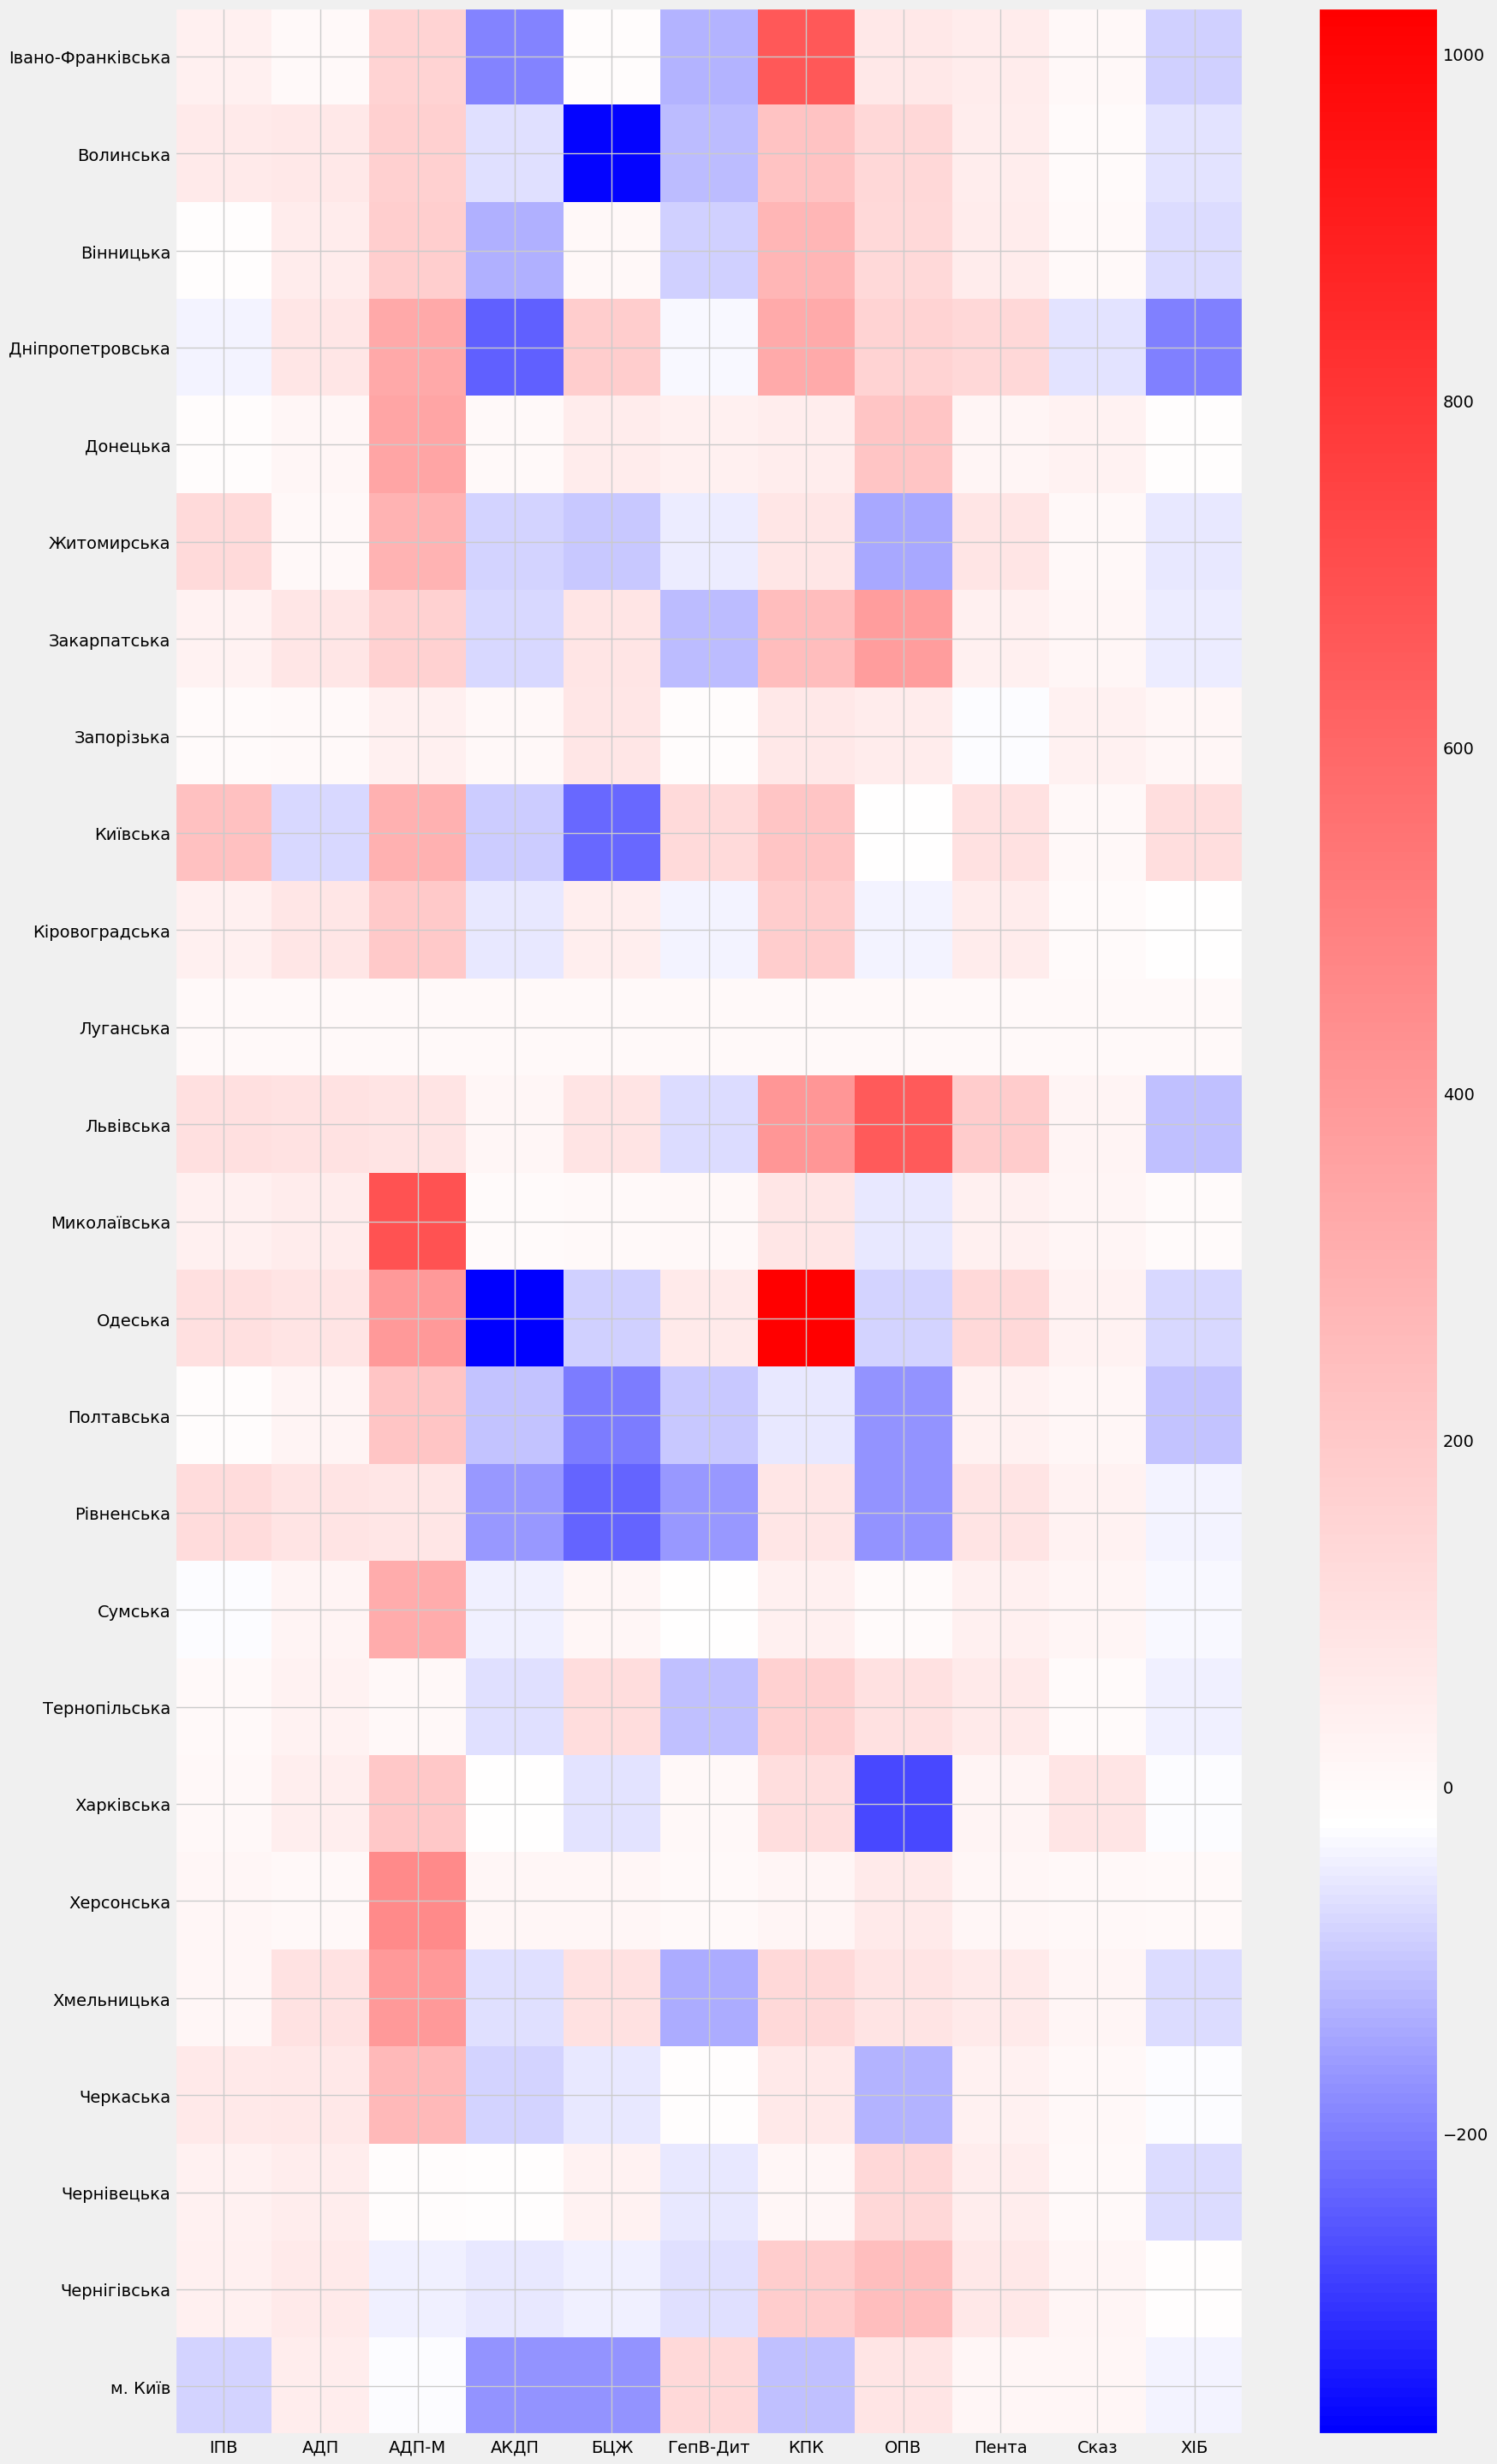

In [ ]:
import matplotlib.colors as mcolors

plt.style.use('fivethirtyeight')

plt.figure(figsize=(20, 35))

cmap = mcolors.LinearSegmentedColormap.from_list(
    "mycmap", [(0, "blue"), (0.25, "white"), (1, "red")]
)

# Assuming 'df' is your DataFrame
plt.imshow(mean_trends, cmap=cmap, interpolation='nearest')

plt.xticks(np.arange(len(mean_trends.columns)), mean_trends.columns)
plt.yticks(np.arange(len(mean_trends.index)), mean_trends.index)

# Show a colorbar
plt.colorbar()

# Show the plot
plt.show()